In [1]:
%cd ..


/Users/eliaweiss/ai/segmentation/MobileSAM


In [2]:
import numpy as np
from tblDetect.TableDetect import TableDetect
from tblDetect.MobileSamBoxes import MobileSamBoxes
import matplotlib.pyplot as plt
from PIL import Image
import torch

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

  
def plot_results(model, pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                fill=False, color=c, linewidth=3))
        cl = p.argmax().item()
        score = p[cl]
        text = f'{model.config.id2label[cl]}: {score:0.2f}'
        
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()
        
def show_anns(anns):
    if len(anns) == 0:
        return
    ax = plt.gca()
    ax.set_autoscale_on(False)
    img = np.ones((anns.shape[1], anns.shape[2], 4))
    # img[:,:,3] = 0
    for ann in range(anns.shape[0]):
        m = anns[ann].bool()
        m=m.cpu().numpy()
        color_mask = np.concatenate([np.random.random(3), [1]])
        img[m] = color_mask
    ax.imshow(img)


def plot_annotations(anns):
    plt.figure(figsize=(10,10))
    background=np.ones_like(sam.image)*255
    plt.imshow(background)
    show_anns(anns)
    plt.axis('off')
    plt.show() 
    # plt.savefig("{}".format("./out/result.jpg"), bbox_inches='tight', pad_inches = 0.0)         



/Users/eliaweiss/ai/segmentation/MobileSAM/tinyvit/tiny_vit.py:656: UserWarning: Overwriting tiny_vit_5m_224 in registry with tinyvit.tiny_vit.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/Users/eliaweiss/ai/segmentation/MobileSAM/tinyvit/tiny_vit.py:656: UserWarning: Overwriting tiny_vit_11m_224 in registry with tinyvit.tiny_vit.tiny_vit_11m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/Users/eliaweiss/ai/segmentation/MobileSAM/tinyvit/tiny_vit.py:656: UserWarning: Overwriting tiny_vit_21m_224 in registry with tinyvit.tiny_vit.tiny_vit_21m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/Users/eliaweiss/ai/segmentation/MobileSAM/tinyvit/tiny_vit.py:656: U

In [3]:
# file_path = "./app/assets/picture1.jpg"
# file_path = "/Users/eliaweiss/Documents/doc2txt/sihach/attachments/img/20231025012642_001.jpg"
file_path = "/Users/eliaweiss/Documents/doc2txt/sihach/need fix/4e7d4235deff4ee2b72d886e12ad0bcf.jpg"
# file_path = "/Users/eliaweiss/Documents/doc2txt/invoices 2/expense (6).jpeg"
img = Image.open(file_path)

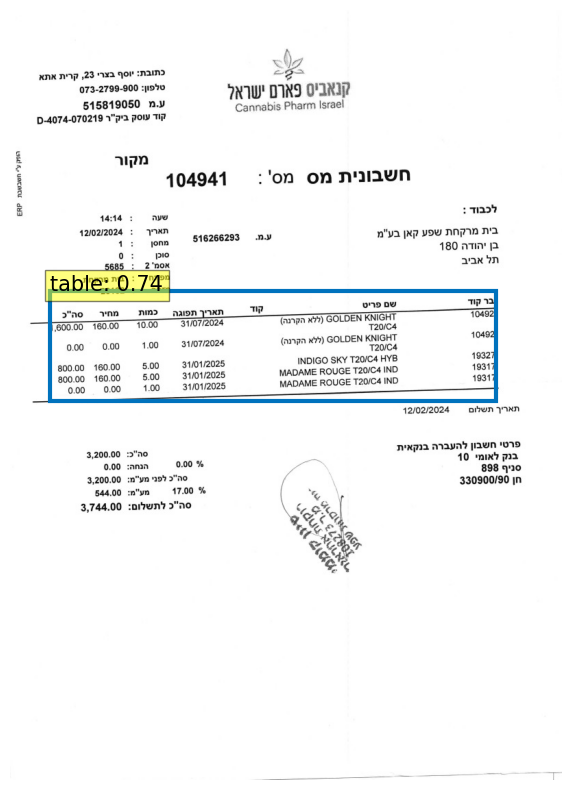

In [4]:
tblDec = TableDetect()
probas, boxes = tblDec.detectTables(img)
plot_results(tblDec.model, img, probas, boxes)


# Crop table with sam

In [5]:
sam = MobileSamBoxes(img)
anns = sam.process(boxes)

checkpoint_load_scucess
shape (1124, 805, 3)
------ total time: (s): 1.8


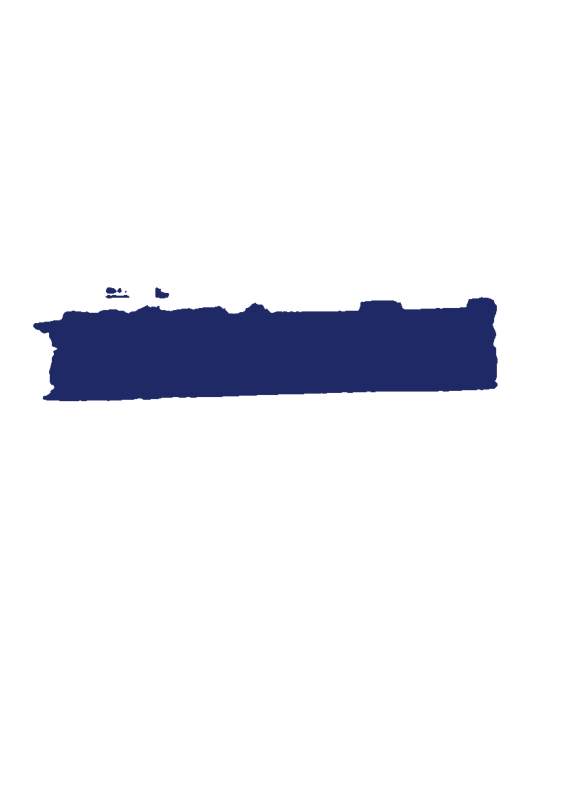

In [6]:
plot_annotations(anns)



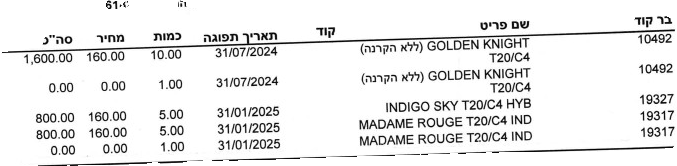

In [7]:
from PIL import Image
import cv2

def create_mask_patch(image, mask):
  """
  Creates a patch from the image containing only the mask region.

  Args:
      image: A PIL image object.
      mask: A NumPy array representing the mask (1 for mask pixels).

  Returns:
      A PIL image object containing the patch from the original image 
      with only the mask region and white background for non-mask pixels.
  """
  mask=mask.cpu().numpy()
  # mask = cv2.dilate(mask, np.ones((13, 13), np.uint8), iterations=1)  
  # Find non-zero elements (mask pixels) in the mask
  mask_coords = np.where(mask != 0)

  # Get minimum and maximum coordinates from the mask pixels
  min_y, min_x = mask_coords[0].min(), mask_coords[1].min()
  max_y, max_x = mask_coords[0].max() + 1, mask_coords[1].max() + 1  # Add 1 for inclusive range

  # Create the bounding box rectangle
  bounding_box = (min_x, min_y, max_x, max_y)


  mask = mask==1
  imgArr = np.array(image)
  imgArr[~mask] = (255,255,255)
  image = Image.fromarray(imgArr)
  # color_mask = np.concatenate([np.random.random(3), [1]])
  # img[m] = color_mask
  # Crop the image using the bounding box
  patch_image = image.crop(bounding_box)
  return patch_image

# Example usage
mask = anns[0]

tbl_patch = create_mask_patch(img, mask)
# patch.show()  # Display the created patch
tbl_patch


# Table structure recognition

In [8]:
from tblDetect.TblStructureDetect import TblStructureDetect
tblStructDetect = TblStructureDetect()
cells = tblStructDetect.detectTableStructure(tbl_patch)


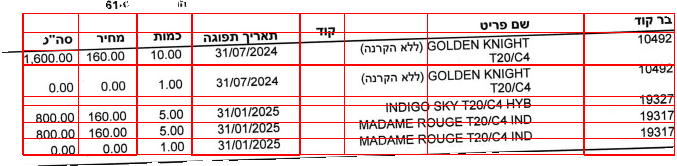

In [10]:
from PIL import ImageDraw

cropped_table_visualized = tbl_patch.copy()
draw = ImageDraw.Draw(cropped_table_visualized)

for cell in cells:
    draw.rectangle(cell["bbox"], outline="red")

cropped_table_visualized

In [11]:
def plot_results_cells(tbl_patch, cells, class_to_visualize):
    if class_to_visualize not in tblStructDetect.id2label.values():
      raise ValueError(f"Class should be one of the available classes {structure_model.config.id2label}")

    plt.figure(figsize=(16,10))
    plt.imshow(tbl_patch)
    ax = plt.gca()

    for cell in cells:
        bbox = cell["bbox"]
        label = cell["label"]

        if label == class_to_visualize:
          xmin, ymin, xmax, ymax = tuple(bbox)

          ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color=np.random.random(3), linewidth=3))
          plt.axis('off')

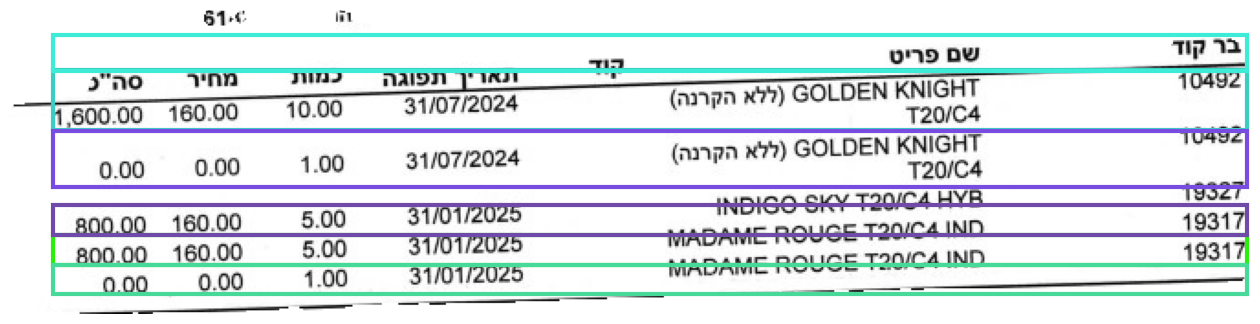

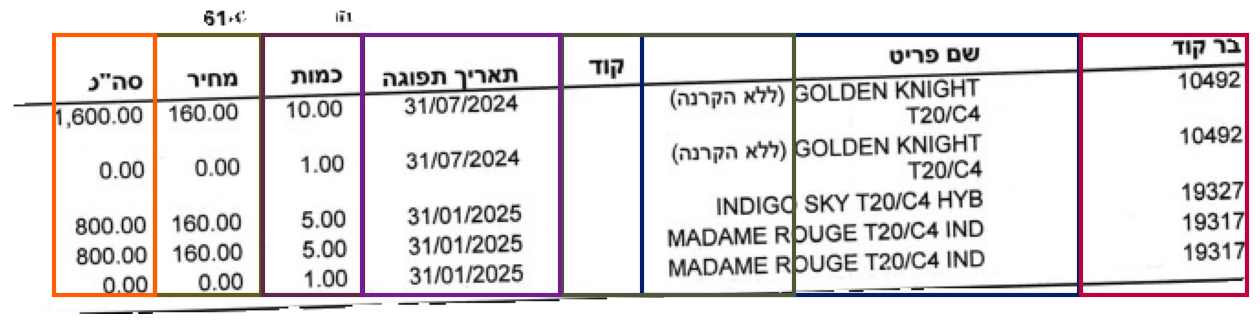

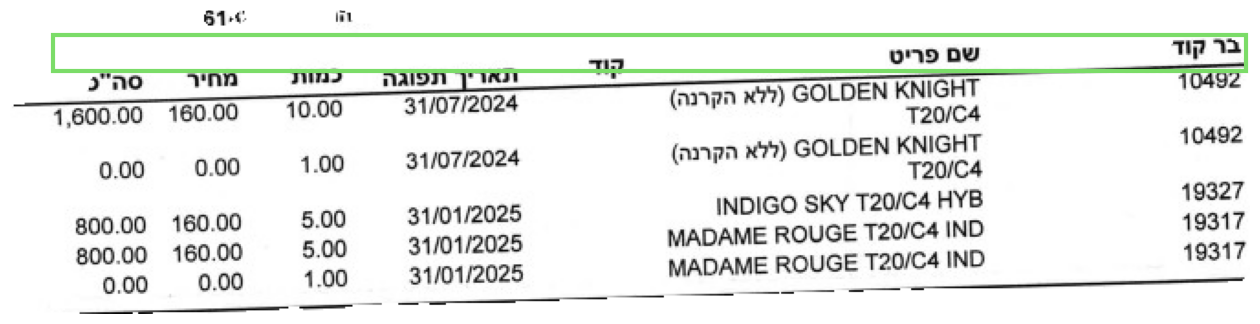

In [12]:
plot_results_cells(tbl_patch,cells, class_to_visualize="table row")
plot_results_cells(tbl_patch, cells, class_to_visualize="table column")
plot_results_cells(tbl_patch,cells, class_to_visualize="table column header")
# plot_results_cells(tbl_patch,cells, class_to_visualize="table projected row header")
# plot_results_cells(tbl_patch,cells, class_to_visualize="table spanning cell")

# align table

In [23]:
image = np.array(img)

In [13]:
m = anns[0].bool()
m=m.cpu().numpy()
mask = np.zeros((anns.shape[1], anns.shape[2], 1), np.uint8)
mask[m] = 255
# mask = ~mask
print(mask.shape)
print(mask.dtype)

(1124, 805, 1)
uint8


In [14]:
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
len(contours)

5

In [21]:
contour = None
rectArea = None
for c in contours:
    _,_,h,w =cv2.boundingRect(c)
    if rectArea is None or rectArea < h*w:
        rectArea = h*w
        contour = c
        
    print(h*w)
rectArea    

102904
175
6
320
207


102904

In [31]:
center, (w,h), angle = cv2.minAreaRect(contour)
bbox = np.int0(cv2.boxPoints((center, (w,h), angle)))
bbox

/var/folders/yb/0c4mt25s0cd6btj71b9f7qfc0000gn/T/ipykernel_23741/1262530620.py:2: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  bbox = np.int0(cv2.boxPoints((center, (w,h), angle)))


array([[ 33, 435],
       [708, 416],
       [712, 553],
       [ 37, 573]])

In [38]:
bRect = cv2.boundingRect(bbox)
x,y,w,h = bRect
x1,y1 = x+w,y+h


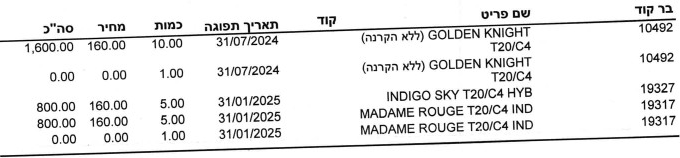

In [43]:
tbl_patch = image[y:y1, x:x1]
Image.fromarray(tbl_patch)

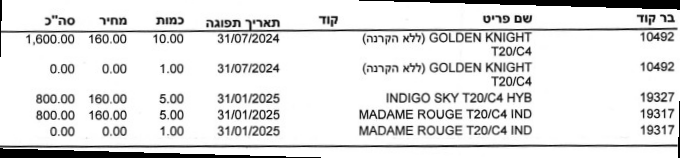

In [44]:
tbl_patch_pil = Image.fromarray(tbl_patch)
# tbl_patch_pil = Image.fromarray(image.copy())
tbl_patch_pil =  tbl_patch_pil.rotate((angle-90), resample=Image.BILINEAR)
tbl_patch_pil

# Find cell from align tbl

In [45]:
from tblDetect.TblStructureDetect import TblStructureDetect
tblStructDetect = TblStructureDetect()
cells = tblStructDetect.detectTableStructure(tbl_patch_pil)


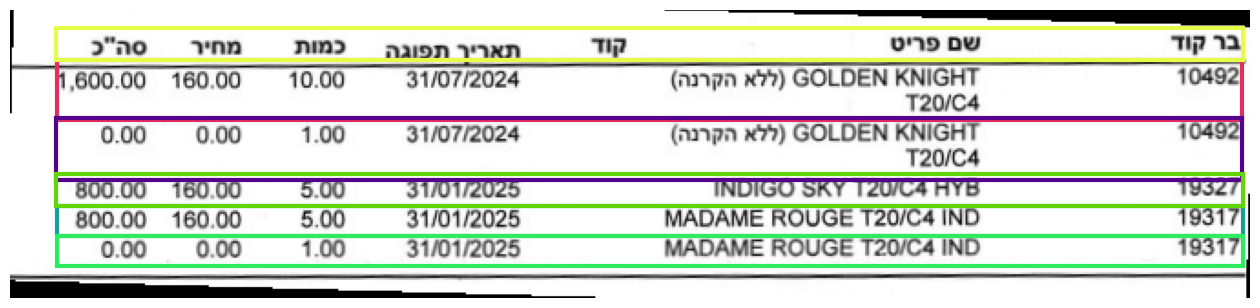

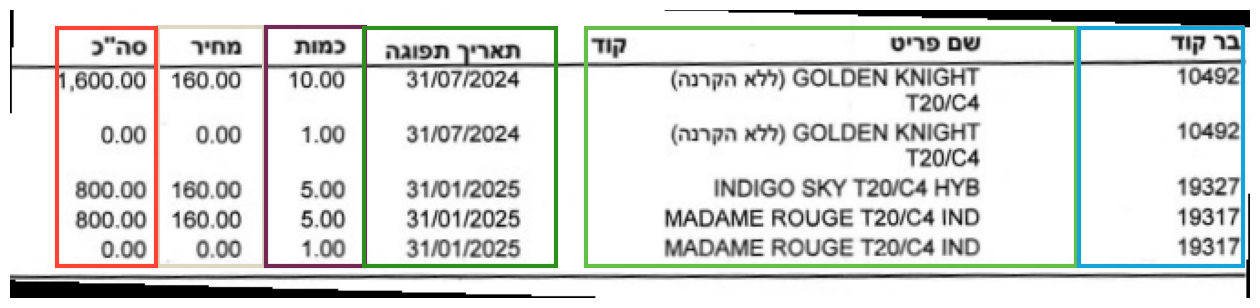

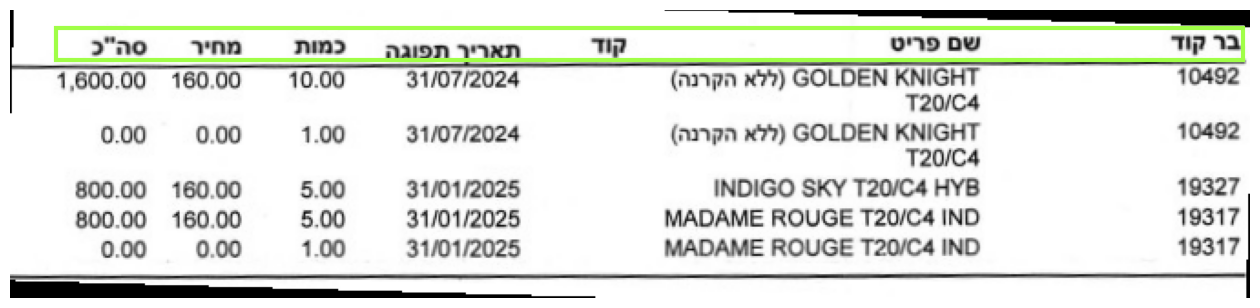

In [46]:
plot_results_cells(tbl_patch_pil,cells, class_to_visualize="table row")
plot_results_cells(tbl_patch_pil, cells, class_to_visualize="table column")
plot_results_cells(tbl_patch_pil,cells, class_to_visualize="table column header")

# Find the inverse homography matrix